## 업비트 시계열 데이터 LSTM 미래 예측 예제
- 지금까지의 동향으로 미래의 흐름을 예측합니다.
- 앞의 window_size(x)를 기준으로 다음 미래 1스텝(y) 를 예측합니다.

### 수정할 변수들
1.   time_step = 앞의 몇개를 가지고 다음을 예측할 것인지 (= window size)
2.   future_step = 몇스탭뒤 미래를 예측할 것인지.
3.   coinName = 코인이름을 바꿔준다. (이름은 업비트 사이트 참고한다. KRW-OOO 형식)
4.   to_date = 과거 언제까지 데이터를 추출할지 정한다.
5. training_percent = 데이터의 몇 %를 학습에 사용할지 정한다

데이터의 크기, 몇분봉 기준, 윈도우 사이즈에 따라 예측결과가 상이하게 바뀐다.
특히 윈도우 사이즈가 중요함.


In [6]:
#수정할 곳
time_step = 50
future_step = 30
training_percent = 0.90

coinName = 'KRW-BTC' #(수정할것)
to_date = '2019-08-08'
type = 'minutes'  #minutes/#, days, weeks, months
scale = '240' #minutes 인경우만 수정(몇분 단위인지)
train_time = 10

In [7]:
import urllib.request
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import math
import json
import datetime
import codecs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from datetime import timedelta

In [8]:
#저장용 빈 데이터 프레임 생성
data_frame = pd.DataFrame(columns=['date', 'open','high','low','final', 'vol'])
data_frame

,date,open,high,low,final,vol


### 업비트 데이터 가져오기



In [9]:
#show_title = 1

# last_date 이전 데이터만 출력
# to_date 이후 데이터만 출력

def get_upbit_date(url, target_date): #날짜 추출하기
  while (True):
      for i in range(0,3):
        try :
            response = requests.get(url)
        except Exception as e:
            print(str(e))
            print('오류가 발생하여 재시도 합니다...')
            time.sleep(3)
            continue
        if str(response) == '<Response [200]>':
            break
      data = response.json()
      end_date = data[-1]['candleDateTime'] #맨끝 데이터
      print(end_date)
      tmp1 = end_date.split('T') #EX) 2021-02-01T06:45:00+00:00
      if tmp1[0] > target_date : #맨끝 시간이 
        break
      tmp2 = tmp1[1].split('+')
      target_date = tmp1[0] + ' ' + tmp2[0]
      next_url = url + '&to=' + target_date    #to=2019-11-27 04:01:00

def get_upbit_data(url, last_date, to_date):
  #global show_title
  global data_frame
  # 데이터 예외처리
  response = ''
  while True:
      try :
          response = requests.get(url)
      except Exception as e:
          print(str(e))
          print('오류가 발생하여 재시도 합니다...')
          time.sleep(3)
          continue
      if str(response) == '<Response [200]>':
          break

  #json 객체화
  data = response.json()
  code = data[0]['code']


  #if show_title:
  #    show_title = 0
  #    print(code)
  #    print("=========================================================")
  #    print("          date         open   high   low   final   vol")
  #    print("=========================================================")

  date = ''
  dateKst = ''
  for i in range(len(data))  :
      dateKst = data[i]['candleDateTimeKst']
      date = data[i]['candleDateTime']
      if (last_date == '' or last_date > date) :
          if (dateKst >= to_date) :
              simpleDate = dateKst.split('+')
              
              #데이터 출력
              #print(simpleDate[0], data[i]['openingPrice'], data[i]['highPrice'], data[i]['lowPrice'], data[i]['tradePrice'], data[i]['candleAccTradeVolume']);
              #print('sequence...' + str(i))
              current_data = pd.DataFrame(
              {
                  'date': [simpleDate[0]],
                  'open': [data[i]['openingPrice']],
                  'high': [data[i]['highPrice']],
                  'low': [data[i]['lowPrice']],
                  'final': [data[i]['tradePrice']],
                  'vol': [data[i]['candleAccTradeVolume']],
              })
              data_frame = data_frame.append(current_data) #데이터 프레임에 얻은 데이터를 차곡차곡 저장시킨다.
          else:
              break

  return date

def get_coin_data_url(coinName, type, scale, cnt=400) :
    #addr = 'https://crix-api-endpoint.upbit.com/v1/crix/candles/'
    addr = 'https://crix-api-cdn.upbit.com/v1/crix/candles/'
    #https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-NPXS&count=200&ciqrandom=1612867691544
    if type == 'minutes' : #분봉이라면
        basic_url = addr + type + '/' + scale + '?code=CRIX.UPBIT.' + coinName +'&count='+str(cnt)
    else : #아니라면
        basic_url = addr + type + '/' + '?code=CRIX.UPBIT.' + coinName +'&count='+str(cnt)

    return basic_url

In [10]:
data_frame = pd.DataFrame(columns=['date', 'open','high','low','final', 'vol'])
end = 0
last_date = ''
basic_url = get_coin_data_url(coinName, type , scale) #type에 따라 url 처리
url = basic_url #url 변수에 추가저장
 
print(url)
get_upbit_date(url, to_date)
 
while (1) :
  last_date = get_upbit_data(url, last_date, to_date)
  tmp1 = last_date.split('T')
  if tmp1[0]  < to_date :
      break
  tmp2 = tmp1[1].split('+')
  target_date = tmp1[0] + ' ' + tmp2[0]
  url = basic_url + '&to=' + target_date    #to=2019-11-27 04:01:00
  print(url)
 
print('Finish')

https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-BTC&count=400
2021-03-25T00:00:00+00:00
https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-BTC&count=400&to=2021-03-25 00:00:00
https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-BTC&count=400&to=2021-01-17 08:00:00
https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-BTC&count=400&to=2020-11-11 16:00:00
https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-BTC&count=400&to=2020-09-06 00:00:00
https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-BTC&count=400&to=2020-07-01 08:00:00
https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-BTC&count=400&to=2020-04-25 16:00:00
https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-BTC&count=400&to=2020-02-19 00:00:00
https://crix-api-cdn.upbit.com/v1/crix/candles/minutes/240?code=CRIX.

### 가져온 데이터 출력

In [11]:
#데이터 출력
pd.options.display.float_format = '{:.8f}'.format #소수점 8자리까지 print시 표시
data_frame = data_frame.sort_values(by=['date']) #오름차순 정렬
data_frame.index = range(0, data_frame.shape[0]) #인덱스 매기기
data_frame

,date,open,high,low,final,vol
0,2019-08-08T01:00:00,13894000.00000000,14085000.00000000,13775000.00000000,14050000.00000000,1168.67908419
1,2019-08-08T05:00:00,14050000.00000000,14307000.00000000,13906000.00000000,14219000.00000000,1787.72003779
2,2019-08-08T09:00:00,14197000.00000000,14307000.00000000,14091000.00000000,14214000.00000000,1866.38450421
3,2019-08-08T13:00:00,14214000.00000000,14240000.00000000,14050000.00000000,14190000.00000000,1576.37647423
4,2019-08-08T17:00:00,14190000.00000000,14256000.00000000,14080000.00000000,14113000.00000000,1185.59650353
...,...,...,...,...,...,...
3967,2021-05-30T05:00:00,41893000.00000000,42994000.00000000,41744000.00000000,42688000.00000000,1041.01878312
3968,2021-05-30T09:00:00,42688000.00000000,42736000.00000000,40580000.00000000,42041000.00000000,2675.76804192
3969,2021-05-30T13:00:00,42041000.00000000,43550000.00000000,41861000.00000000,43109000.00000000,2244.87040786
3970,2021-05-30T17:00:00,43109000.00000000,43659000.00000000,42400000.00000000,43659000.00000000,1348.92205382


In [12]:
#데이터 분할
#splited_data = data_frame.loc[0:14664]
#splited_data

In [13]:
# 결측치 제거 (LOSS NAN 제거)
data = data_frame.dropna()

In [14]:
#예측할것은 (고점-저점) 평균 데이터
high_prices = data['high'].values
low_prices = data['low'].values
mid_prices = (high_prices + low_prices) / 2

In [15]:
#데이터 확인
mid_prices[0:10]

array([13930000., 14106500., 14199000., 14145000., 14168000., 14048000.,
       13953000., 14083500., 14230000., 14154500.])

### 값 시각화(plot)

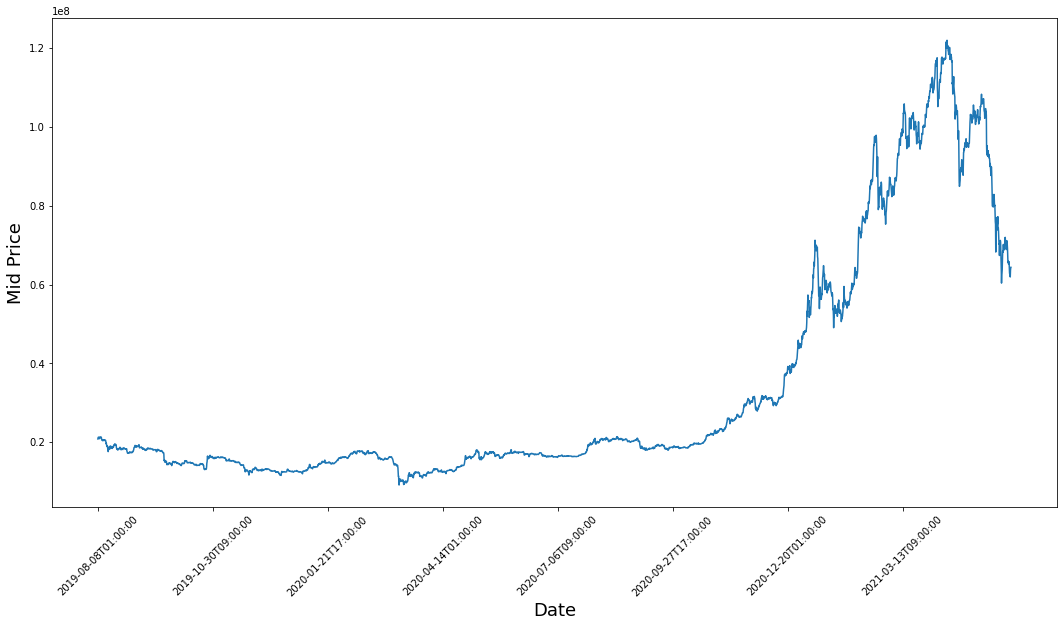

In [16]:
plt.figure(figsize = (18,9))
mid_list = data['low']+data['high'] / 2.0
plt.plot(range(data.shape[0]), (mid_list))
plt.xticks(range(0 , data.shape[0] , 500) , data['date'].loc[::500],rotation=45) #눈금 45도 회전해서 출력
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### 데이터 전처리(PRE PROCESSING)

In [17]:
#LSTM은 데이터에 민감하므로 0~1 값으로 변환해준다.
scaler=MinMaxScaler(feature_range=(0,1))
mid_prices=scaler.fit_transform(np.array(mid_prices).reshape(-1,1))

In [18]:
##학습, 테스트 데이터 나누기

training_size=int(len(mid_prices)* training_percent)
test_size=len(mid_prices)-training_size
train_data,test_data = mid_prices[0:training_size,:],mid_prices[training_size:len(mid_prices),:1]

In [19]:
#학습데이터 크기, 테스트 데이터 크기 출력
training_size , test_size

(3574, 398)

### 데이터셋 만들기

In [20]:
# convert an array of values into a dataset matrix
# 데이터셋 만들기
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [21]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
print(X_train.shape), print(y_train.shape)

(3523, 50)
(3523,)


(None, None)

In [23]:
print(X_test.shape), print(ytest.shape)

(347, 50)
(347,)


(None, None)

In [24]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### LSTM 모델 제작

In [25]:
#model=Sequential()
#model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1))) #앞의 100개로 다음 1개 예측 (처음 LSTM x값엔 time_step 크기의 데이터가 들어간다.)
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error',optimizer='adam')

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [26]:
#model.summary()

### 모델 학습 시키기

In [27]:
model.fit(X_train,y_train,validation_data=(X_test,ytest), epochs=train_time ,batch_size=64 , verbose=1)

Epoch 1/10
56/56 [==============================] - 27s 48ms/step - loss: 0.0119 - val_loss: 0.0041
Epoch 2/10
56/56 [==============================] - 1s 27ms/step - loss: 8.9692e-04 - val_loss: 0.0018
Epoch 3/10
56/56 [==============================] - 1s 26ms/step - loss: 6.7968e-04 - val_loss: 0.0028
Epoch 4/10
56/56 [==============================] - 1s 26ms/step - loss: 4.5200e-04 - val_loss: 0.0015
Epoch 5/10
56/56 [==============================] - 1s 26ms/step - loss: 4.2360e-04 - val_loss: 0.0154
Epoch 6/10
56/56 [==============================] - 1s 26ms/step - loss: 6.2335e-04 - val_loss: 0.0138
Epoch 7/10
56/56 [==============================] - 1s 26ms/step - loss: 4.3407e-04 - val_loss: 0.0196
Epoch 8/10
56/56 [==============================] - 1s 26ms/step - loss: 4.4711e-04 - val_loss: 6.9679e-04
Epoch 9/10
56/56 [==============================] - 1s 26ms/step - loss: 2.3759e-04 - val_loss: 0.0015
Epoch 10/10
56/56 [==============================] - 1s 26ms/step - loss

In [28]:
# 값 predict하기
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [29]:
#0~1로 바뀐값들 원래대로 돌리기
train_predict = scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [30]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

22952906.158569455

In [31]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

67806494.4141645

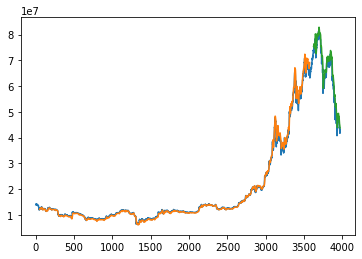

In [32]:
### Plotting 
# shift train predictions for plotting
look_back= time_step
trainPredictPlot = np.empty_like(mid_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(mid_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(mid_prices)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(mid_prices))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [33]:
#이제 테스트 데이터에서 이전 100일전 데이터를 가져와야 한다.
len(test_data)

398

In [34]:
split_index = len(test_data) - time_step #*전체 테스트 데이터 - 100 이후의 값만 가져온다(맨끝의 100일것)
x_input=test_data[split_index:].reshape(1,-1)
x_input.shape

(1, 50)

In [35]:
temp_input=list(x_input) #리스트 변환
temp_input=temp_input[0].tolist()
len(temp_input)

50

In [36]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps= time_step
i=0

while(i < future_step): #다음 29 스탭 미래 (미래 30번까지 예측)
    
    if(len(temp_input) > time_step): #100개가 넘어가면
        #print(temp_input)
        x_input=np.array(temp_input[1:])  #1칸 밀기
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1) 
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1)) 
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.50288737]
51
1 day input [0.54766269 0.54958886 0.55020656 0.54867891 0.52889916 0.50770467
 0.49039573 0.45812245 0.47488675 0.48129624 0.48831679 0.51054079
 0.52838773 0.52662761 0.53943995 0.54648707 0.54139269 0.53168214
 0.53077219 0.53690936 0.54046281 0.54262809 0.55776511 0.55799094
 0.55050545 0.54440814 0.54600885 0.53366809 0.52966963 0.53892188
 0.54953573 0.54148567 0.54075506 0.53257881 0.51498426 0.50252394
 0.50426414 0.50405159 0.49674544 0.50175348 0.50121548 0.48876845
 0.47668008 0.47592954 0.47990143 0.47045657 0.48437147 0.48867546
 0.49018983 0.50288737]
1 day output [[0.50878125]]
2 day input [0.54958886 0.55020656 0.54867891 0.52889916 0.50770467 0.49039573
 0.45812245 0.47488675 0.48129624 0.48831679 0.51054079 0.52838773
 0.52662761 0.53943995 0.54648707 0.54139269 0.53168214 0.53077219
 0.53690936 0.54046281 0.54262809 0.55776511 0.55799094 0.55050545
 0.54440814 0.54600885 0.53366809 0.52966963 0.53892188 0.54953573
 0.54148567 0.54075506 0.53257881 0.5

In [37]:
day_new=np.arange(1 , time_step+1) #이전 100개의 경향
day_pred=np.arange(time_step+1 ,time_step + 1 + future_step) #이후 창조된 30개의 경향
print(len(day_new))
print(len(day_pred))

50
30


In [38]:
len(mid_prices)

3972

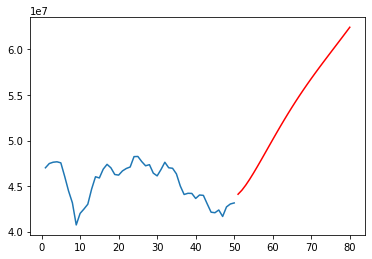

In [39]:
#스칼라값을 원래대로 돌려준다.

plt.plot(day_new , scaler.inverse_transform(mid_prices[len(mid_prices) - time_step:])) #이전 100개의 경향 출력 (전체 mid data에서 뒤의 100개만)
plt.plot(day_pred , scaler.inverse_transform(lst_output), 'r') #예측된 output들 출력

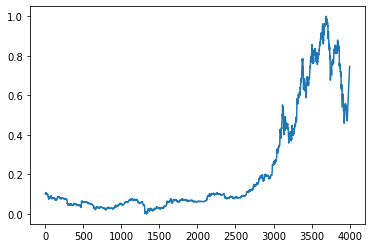

In [40]:
df3 = mid_prices.tolist()  #평균값을 리스트로 변환해서 넣는다
df3.extend(lst_output) #끊기지 않게 하기 위해 예측값을 끝부분에 추가한다. (잇는다)
plt.plot(df3)

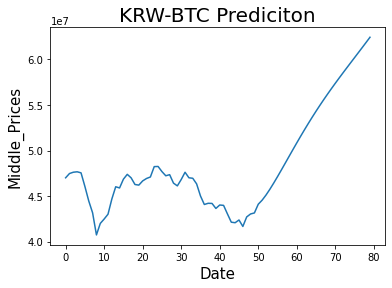

In [41]:
origin = scaler.inverse_transform(df3).tolist() #df3 값을 원래대로 돌려준다. 
slice_index = -(len(day_new) + len(day_pred)) #앞의 참고한 데이터 + 추가로 예측한 데이터 개수
plt.plot(origin[slice_index:])

plt.title(coinName + ' Prediciton', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Middle_Prices', fontsize=15)


plt.show()

In [42]:

def make_step_date(type_, step): #미래예측 x축 제작 함수
  result = []
  date_list = data_frame['date'].to_list()
  based_data = date_list[-len(day_new):]

  latest_time = based_data[-1]
  latest_time = latest_time.replace("T", "-")
  date_obj = datetime.datetime.strptime(latest_time, '%Y-%m-%d-%H:%M:%S')

  if type_ == 'days':
    for i in range(step):
      date_obj = date_obj + timedelta(days = 1)
      result.append(str(date_obj))
      #print(date_obj)
  elif type_ == 'minutes':
    for i in range(step):
      date_obj = date_obj + timedelta(minutes = int(scale))
      result.append(str(date_obj))
      #print(date_obj)
  return result

In [43]:
date_list = data_frame['date'].to_list()
based_data = date_list[-len(day_new):]
future_date = make_step_date(type, future_step)

based_data.extend(future_date) #x축 제작 완료

In [44]:
print(based_data)

['2021-05-22T17:00:00', '2021-05-22T21:00:00', '2021-05-23T01:00:00', '2021-05-23T05:00:00', '2021-05-23T09:00:00', '2021-05-23T13:00:00', '2021-05-23T17:00:00', '2021-05-23T21:00:00', '2021-05-24T01:00:00', '2021-05-24T05:00:00', '2021-05-24T09:00:00', '2021-05-24T13:00:00', '2021-05-24T17:00:00', '2021-05-24T21:00:00', '2021-05-25T01:00:00', '2021-05-25T05:00:00', '2021-05-25T09:00:00', '2021-05-25T13:00:00', '2021-05-25T17:00:00', '2021-05-25T21:00:00', '2021-05-26T01:00:00', '2021-05-26T05:00:00', '2021-05-26T09:00:00', '2021-05-26T13:00:00', '2021-05-26T17:00:00', '2021-05-26T21:00:00', '2021-05-27T01:00:00', '2021-05-27T05:00:00', '2021-05-27T09:00:00', '2021-05-27T13:00:00', '2021-05-27T17:00:00', '2021-05-27T21:00:00', '2021-05-28T01:00:00', '2021-05-28T05:00:00', '2021-05-28T09:00:00', '2021-05-28T13:00:00', '2021-05-28T17:00:00', '2021-05-28T21:00:00', '2021-05-29T01:00:00', '2021-05-29T05:00:00', '2021-05-29T09:00:00', '2021-05-29T13:00:00', '2021-05-29T17:00:00', '2021-05-2

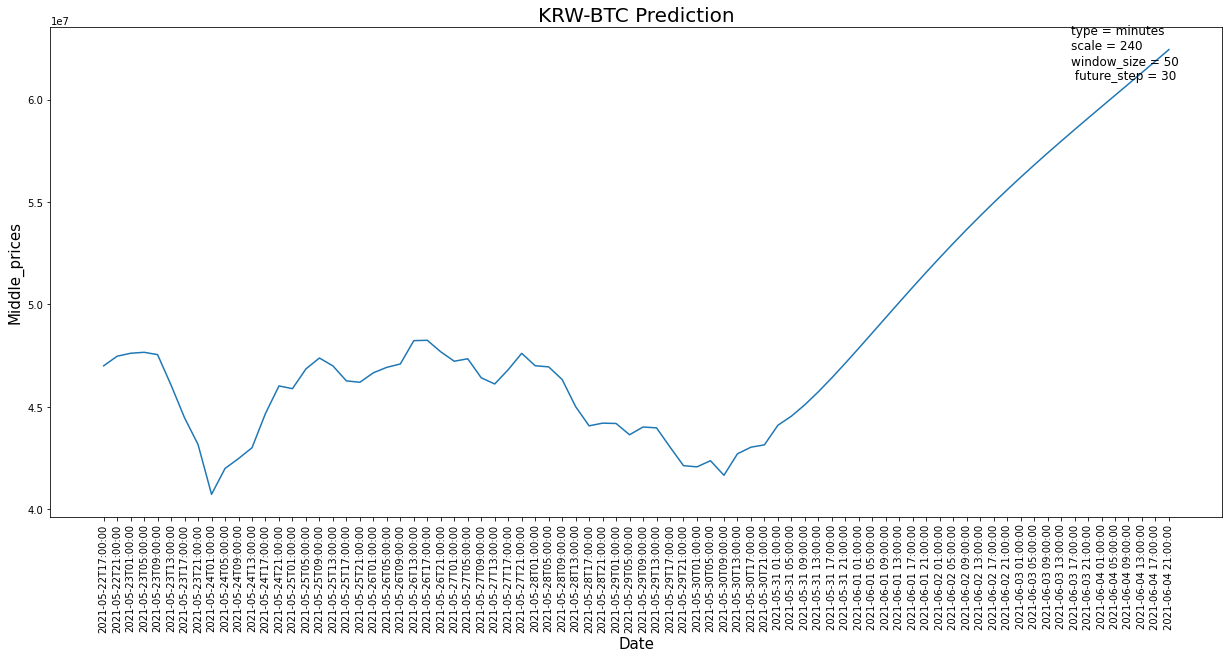

In [45]:
origin = scaler.inverse_transform(df3).tolist() #df3 값을 원래대로 돌려준다. 
slice_index = -(len(day_new) + len(day_pred)) #앞의 참고한 데이터 + 추가로 예측한 데이터 개수

plt.figure(figsize = (21,9))

plt.plot(range(len(based_data)), origin[slice_index:])
plt.xticks(range(0 , len(based_data)) , labels = based_data ,rotation=90) #눈금 45도 회전해서 출력


plt.title(coinName + ' Prediction', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Middle_prices', fontsize=15)
plt.figtext(.8, .8, f"type = {type}\nscale = {scale}\nwindow_size = {time_step}\n future_step = {future_step}", fontsize=12)

plt.show()
